In [1]:
# JAX imports
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# Helpful misc imports
import matplotlib.pyplot as plt
from jaxoplanet.light_curves import limb_dark_light_curve

# jaxoplanet imports
from jaxoplanet.orbits.keplerian import Central, System
from jaxoplanet.units import unit_registry as ureg
from tqdm import tqdm

from eclipsoid import limb_dark_oblate_lightcurve

# squishyplanet imports
from squishyplanet import OblateSystem

# Benchmarking eclipsoid with other methods:

Let's benchmark eclipsoid against squishyplanet

/Users/uqsdhola/opt/anaconda3/envs/squishyplanet/lib/python3.10/site-packages/matplotlib/cbook.py:1355: UserWarning: The unit of a Quantity is stripped when downcasted to an array.
  return np.asarray(x, float)


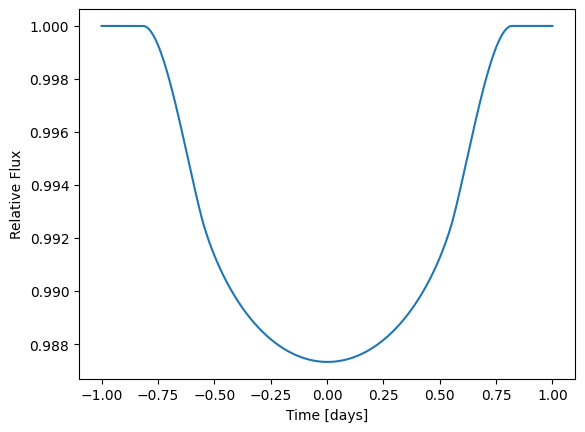

In [2]:
poly_limbdark_order = 2
times = (
    jnp.linspace(-1, 1, int(2 * 24 * 60 / 6)) * ureg.day
)  # 2 days at 10 minute cadence
key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, num=8)

u = jax.random.uniform(subkeys[6], shape=(poly_limbdark_order,))
star_mass = jax.random.uniform(subkeys[0], minval=0.1, maxval=1.5) * ureg.M_sun
semimajor_axis = jax.random.uniform(subkeys[1], minval=0.005, maxval=5.0) * ureg.au
impact_param = jax.random.uniform(subkeys[2], minval=0.0, maxval=1.0)
planet_rad = jax.random.uniform(subkeys[3], minval=0.001, maxval=0.25) * ureg.R_sun
eccentricity = jax.random.uniform(subkeys[4], minval=0.0, maxval=0.9)
omega = jax.random.uniform(subkeys[5], minval=0.0, maxval=2 * jnp.pi)
Omega = jnp.pi

star = Central(radius=1 * ureg.R_sun, mass=star_mass)
planet = (
    System(star)
    .add_body(
        time_transit=0.0,
        semimajor=semimajor_axis,
        impact_param=impact_param,
        radius=planet_rad,
        eccentricity=eccentricity,
        omega_peri=omega * ureg.rad,
        asc_node=Omega * ureg.rad,
        mass=0.0,
    )
    .bodies[0]
)

jaxoplanet_lc = 1 + limb_dark_light_curve(planet, u)(times)

fig, ax = plt.subplots()
ax.plot(times, jaxoplanet_lc)
ax.set(xlabel="Time [days]", ylabel="Relative Flux");

/Users/uqsdhola/opt/anaconda3/envs/squishyplanet/lib/python3.10/site-packages/matplotlib/cbook.py:1355: UserWarning: The unit of a Quantity is stripped when downcasted to an array.
  return np.asarray(x, float)


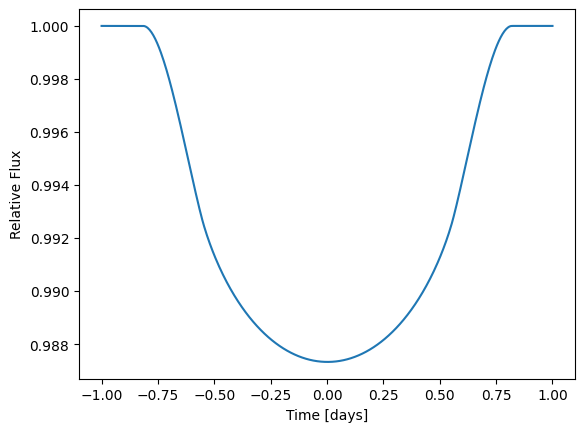

In [3]:
# squishyplanet expects angles between 0 and 2pi
Omega = jnp.arctan2(
    planet.sin_asc_node.to(ureg.radian).magnitude,
    planet.cos_asc_node.to(ureg.radian).magnitude,
)
Omega = jnp.where(Omega < 0, Omega + 2 * jnp.pi, Omega)

omega = jnp.arctan2(
    planet.sin_omega_peri.to(ureg.radian).magnitude,
    planet.cos_omega_peri.to(ureg.radian).magnitude,
)
omega = jnp.where(omega < 0, omega + 2 * jnp.pi, omega)

state = {
    "t_peri": planet.time_peri.to(ureg.day).magnitude,
    "times": times.to(ureg.day).magnitude,
    "period": planet.period.to(ureg.day).magnitude,
    "a": planet.semimajor.to(ureg.R_sun).magnitude,
    "e": planet.eccentricity.to(ureg.dimensionless).magnitude,
    "i": planet.inclination.to(ureg.radian).magnitude,
    "Omega": Omega,
    "omega": omega,
    "f1": 0.0,  # this is a perfectly spherical planet for comparison, so f1 = f2 = 0
    "f2": 0.0,
    "r": planet.radius.to(ureg.R_sun).magnitude,
    "obliq": 0.0,
    "prec": 0.0,
    "ld_u_coeffs": jnp.array(u),
    "tidally_locked": False,
}

s = OblateSystem(**state)

squishyplanet_lc = s.lightcurve()

fig, ax = plt.subplots()
ax.plot(times, squishyplanet_lc)
ax.set(xlabel="Time [days]", ylabel="Relative Flux");

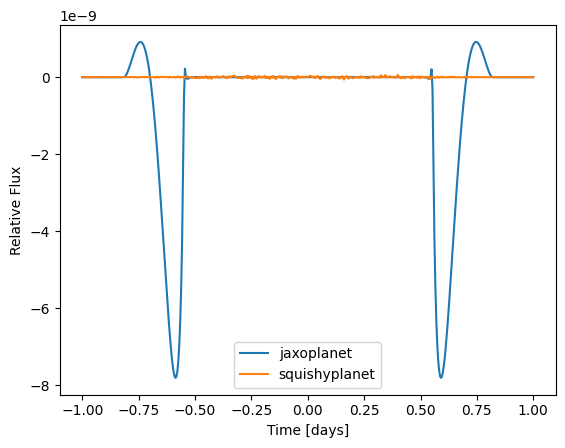

In [4]:
comparison_lc = 1 + limb_dark_light_curve(planet, u, order=100)(times)

fig, ax = plt.subplots()
ax.plot(times.magnitude, jaxoplanet_lc - comparison_lc, label="jaxoplanet")
ax.plot(times.magnitude, squishyplanet_lc - comparison_lc, label="squishyplanet")
ax.set(xlabel="Time [days]", ylabel="Relative Flux")
ax.legend()

In [5]:
oblateness = 0.3
obliquity = 27.3  # degrees
eclipsoid_lc = limb_dark_oblate_lightcurve(planet, u, oblateness=oblateness, obliquity=jnp.radians(obliquity))(times)

In [6]:
state = {
    "t_peri": planet.time_peri.to(ureg.day).magnitude,
    "times": times.to(ureg.day).magnitude,
    "period": planet.period.to(ureg.day).magnitude,
    "a": planet.semimajor.to(ureg.R_sun).magnitude,
    "e": planet.eccentricity.to(ureg.dimensionless).magnitude,
    "i": planet.inclination.to(ureg.radian).magnitude,
    "Omega": Omega,
    "omega": omega,
    "ld_u_coeffs": jnp.array(u),
    "tidally_locked": False,
    "parameterize_with_projected_ellipse": True,
    'projected_effective_r':planet.radius.to(ureg.R_sun).magnitude,
    'projected_f':oblateness,
    'projected_theta':jnp.radians(-obliquity)
}

s = OblateSystem(**state)
squishyplanet_oblate_lc = s.lightcurve()


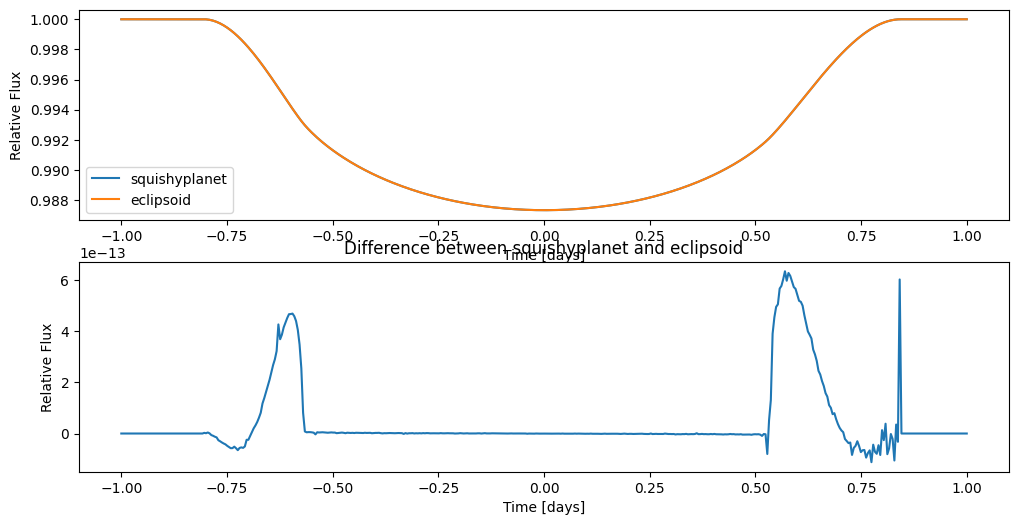

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].plot(times.magnitude, squishyplanet_oblate_lc, label="squishyplanet")
ax[0].plot(times.magnitude, eclipsoid_lc, label="eclipsoid")
ax[0].set(xlabel="Time [days]", ylabel="Relative Flux")
ax[0].legend()
ax[1].plot(times.magnitude, squishyplanet_oblate_lc - eclipsoid_lc)
ax[1].set(xlabel="Time [days]", ylabel="Relative Flux")
ax[1].set_title("Difference between squishyplanet and eclipsoid")
plt.show()

## Testing at a variety of obliquities and oblatenesses:

In [8]:
from tqdm import tqdm
oblatenesses = jnp.linspace(0.0, 0.3, 10)
obliquities = jnp.linspace(-90, 90, 10)

for oblateness in tqdm(oblatenesses):
    for obliquity in obliquities:
        squishyplanet_oblate_lc = s.lightcurve({'projected_f':oblateness, 'projected_theta':jnp.radians(-obliquity)}) 
        eclipsoid_lc = limb_dark_oblate_lightcurve(planet, u, oblateness=oblateness, obliquity=jnp.radians(obliquity))(times)
        #print(jnp.max(jnp.abs(squishyplanet_oblate_lc - eclipsoid_lc)))
        assert jnp.max(jnp.abs(squishyplanet_oblate_lc - eclipsoid_lc))<1e-9, f"Failed for oblateness {oblateness} and obliquity {obliquity}"
print("All tests passed!")
        
        

100%|██████████| 10/10 [01:08<00:00,  6.81s/it]

All tests passed!
